In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [2]:
#Load the modules

from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
import gc

from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D, Input, MaxPooling2D, UpSampling2D
#just some network parameters, see above link regarding the layers for details
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback


from keras.utils import plot_model

from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import time

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import scale
from sklearn.random_projection import GaussianRandomProjection

from scipy.stats import kurtosis

import matplotlib.pyplot as plt


# 3. Loading the data
We'll start by creating a pandas data frame containing the path of all the files in the `train_path` folder and then read the matching labels from the provided csv file.

## Load the labels and filenames

In [3]:
#set paths to training and test data
path = '..\\data\\PCam\\' #adapt this path, when running locally
train_path = path + 'train\\'
test_path = path + 'test\\'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split("\\")[-1].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path + "train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(3) # print the first three entrys

,path,id,label
0,..\data\PCam\train\00001b2b5609af42ab0ab276dd4...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,..\data\PCam\train\000020de2aa6193f4c160e398a8...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,..\data\PCam\train\00004aab08381d25d315384d646...,00004aab08381d25d315384d646f5ce413ea24b1,0


## Load the images

Now, we will load some of the images. As [interactive kernels with GPU](https://www.kaggle.com/docs/kernels#the-kernels-environment) currently offer about 14 GB of RAM, we will take care to keep the images in the uint8 format (i.e. pixel values are integers between 0 and 255) to reduce the memory footprint. Processing of the images often requires converting them to float32, which would require additional space.

We'll declare a function to load a set number of images and then load 10000 images.

In [4]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    gc.collect()
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,32*32],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
            
        if i % 9000 == 0:
            gc.collect()
            print("COLLECTED MEMORY")
        
        img = cv2.imread(row['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        width, height = img.shape   # Get dimensions
#         print(X[i].shape)
        left = (width - 32)//2
        top = (height - 32)//2
        right = (width + 32)//2
        bottom = (height + 32)//2
        cropped = img[top:bottom, left:right].ravel()
        X[i] = cropped
          
    return X,y

def load_data_CNN(N,df):
    """ This functions loads N images using the data df
    """
    gc.collect()
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,32,32,1],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
            
        if i % 9000 == 0:
            gc.collect()
            print("COLLECTED MEMORY")
        
        img = cv2.imread(row['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        width, height = img.shape   # Get dimensions
#         print(X[i].shape)
        left = (width - 32)//2
        top = (height - 32)//2
        right = (width + 32)//2
        bottom = (height + 32)//2
        cropped = img[top:bottom, left:right].reshape(32, 32, 1)
        X[i] = cropped
          
    return X,y

In [5]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# Setup the model
We will now focus on creating a simple model for this problem. This is usually the point, where you would want to start considering our previous conclusions, but to keep it simple, we will assume, we did not draw any meaningful conclusions. As the data is - in comparison to other Kaggle challenges - relatively well balanced and accesible, this should be ok. You can use the insight to craft a better model later!

Let's start by loading all the data, not just a subset as before. This will likely require a few minutes. However, we only need to do it once.

In [6]:
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY
COLLECTED MEMORY



We will use the garbage collector and unbind some variables to free up space in our RAM.

In [7]:
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

Now, we will split the data into a [training and validation set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets). Due to the RAM limitations, we will just do this in-place by specifying an index at which we will split. We'll use 80% of the data for training and 20% to validate that our model can generalize to new data. After that, to avoid any influence of a possible previous sorting of data we will shuffle the data (in-place).

In [8]:
training_portion = 0.4 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(420) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

X = None
y = None

gc.collect()

0

In [9]:
X_train.shape

(88010, 1024)

In [10]:
non_cancer_count = np.count_nonzero(y_test==0)
cancer_count = np.count_nonzero(y_test==1)

In [11]:
cancer_count / (non_cancer_count + cancer_count)

0.404370715449002

In [12]:
non_cancer_count / (non_cancer_count + cancer_count)

0.595629284550998

In [13]:
non_cancer_count

78632

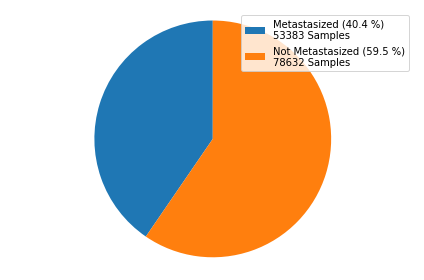

In [14]:
labels = ["Metastasized (40.4 %)\n53383 Samples", "Not Metastasized (59.5 %)\n78632 Samples"]
sizes = [cancer_count, non_cancer_count]
patches, texts = plt.pie(sizes, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()

In [15]:
def kmean_fitter(X_data):
    kmeans_models = []
    kmeans_times = []
    for i in range(1, 11):
        start_time = time.time();
        kmeans = KMeans(n_clusters=i, random_state=420).fit(X_data)
        kmeans_times.append(time.time() - start_time)
        kmeans_models.append(kmeans)
        print("COMPLETED " + str(i))
    
    return kmeans_models, kmeans_times

In [15]:
kmeans_models, kmeans_times = kmean_fitter(X_train)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5
COMPLETED 6
COMPLETED 7
COMPLETED 8
COMPLETED 9
COMPLETED 10


In [16]:
def gmm_fitter(X_data):
    gmm_models = []
    gmm_times = []
    for i in range(1, 11):
        start_time = time.time();
        gmm_model = GaussianMixture(n_components=i, random_state=420).fit(X_data)
        gmm_times.append(time.time() - start_time)
        gmm_models.append(gmm_model)
        print("COMPLETED " + str(i))
    return gmm_models, gmm_times

In [17]:
gmm_models, gmm_times = gmm_fitter(X_train)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5
COMPLETED 6
COMPLETED 7
COMPLETED 8
COMPLETED 9
COMPLETED 10


In [18]:
def kmean_stats(X_data, y_data, kmeans_models):
    cluster_kmeans=[]
    sse_kmeans=[]
    purity_kmeans=[]
    homo_kmeans=[]
    for i in range(0, 10):
        pred = kmeans_models[i].predict(X_data)
        sse_kmeans.append(kmeans_models[i].inertia_)
        purity_kmeans.append(purity_score(y_data, pred))
        homo_kmeans.append(metrics.v_measure_score(y_data, pred))
        cluster_kmeans.append(i + 1)
        print("completed " + str(i + 1))
    
    return cluster_kmeans, sse_kmeans, purity_kmeans, homo_kmeans


In [19]:
cluster_kmeans, sse_kmeans, purity_kmeans, homo_kmeans = kmean_stats(X_train, y_train, kmeans_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


In [20]:
def gmm_stats(X_train_data, y_train_data, gmm_models):
    cluster_gmm=[]
    homo_gmm=[]
    purity_gmm=[]
    for i in range(0, 10):
        pred = gmm_models[i].predict(X_train_data)
        purity_gmm.append(purity_score(y_train_data, pred))
        homo_gmm.append(metrics.v_measure_score(y_train_data, pred))
        cluster_gmm.append(i + 1)
        print("completed " + str(i + 1))
    return cluster_gmm, homo_gmm, purity_gmm

In [21]:
cluster_gmm, homo_gmm, purity_gmm = gmm_stats(X_train, y_train, gmm_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


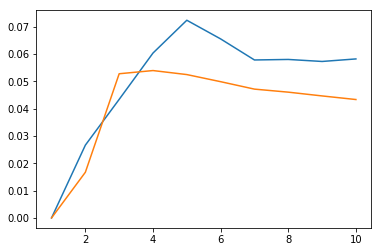

In [22]:
plt.plot(cluster_gmm, homo_gmm)
plt.plot(cluster_kmeans, homo_kmeans)

# plt.plot(xs, ys)

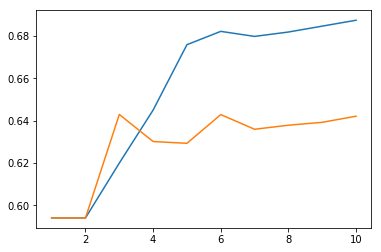

In [23]:
plt.plot(cluster_gmm, purity_gmm)
plt.plot(cluster_kmeans, purity_kmeans)

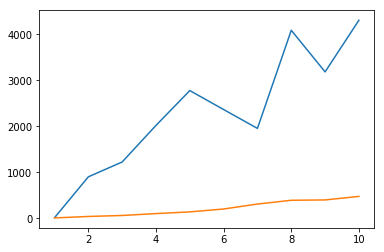

In [24]:
plt.plot(cluster_gmm, gmm_times)
plt.plot(cluster_kmeans, kmeans_times)

In [25]:
best_gmm = gmm_models[4]
best_kmean = kmeans_models[2]

In [26]:
best_kmean.cluster_centers_

array([[214.10625612, 214.21923111, 214.32010323, ..., 216.23542761,
        215.87020557, 215.79531904],
       [112.33431971, 112.09993219, 112.23756242, ..., 111.34221071,
        110.98387892, 111.33755625],
       [157.55768417, 157.79083822, 157.75240225, ..., 157.7993594 ,
        157.54517435, 157.64824439]])

In [27]:
best_gmm.covariances_.shape

(5, 1024, 1024)

In [28]:
contingency_matrix_gmm = metrics.cluster.contingency_matrix(y_train, best_gmm.predict(X_train))

In [29]:
np.sum(np.amax(contingency_matrix_gmm, axis=0)) / np.sum(contingency_matrix_gmm) 

0.6758436541302125

In [119]:
np.amax(contingency_matrix_gmm, axis=0)/np.sum(contingency_matrix_gmm, axis=0)

array([0.89979239, 0.79806556, 0.7843708 , 0.55349629, 0.61096566])

In [31]:
contingency_matrix_kmeans = metrics.cluster.contingency_matrix(y_train, best_kmean.predict(X_train))

In [121]:
contingency_matrix_kmeans

array([[18182, 19699, 14395],
       [ 4289, 12747, 18698]])

In [32]:
np.sum(np.amax(contingency_matrix_kmeans, axis=0)) / np.sum(contingency_matrix_kmeans) 

0.6428701283945006

In [33]:
np.amax(contingency_matrix_kmeans, axis=0)/np.sum(contingency_matrix_kmeans, axis=0)

array([0.80913177, 0.60713185, 0.56501375])

In [16]:
covar_matrix = PCA()
scaled_X_train = scale(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [17]:
covar_matrix.fit(scaled_X_train)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

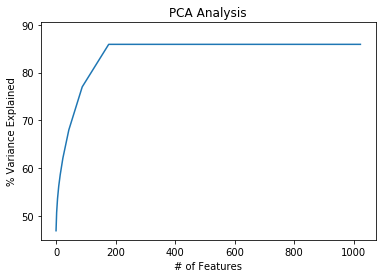

In [18]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(45,90.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

In [19]:
covar_matrix = PCA(n_components = 178)

In [20]:
start = time.time()
covar_matrix.fit(scaled_X_train)
end = time.time()
pca_x_scaled_time = end - start
covar_matrix.fit(scaled_X_train)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

In [21]:
pca_x_scaled_time

7.768227577209473

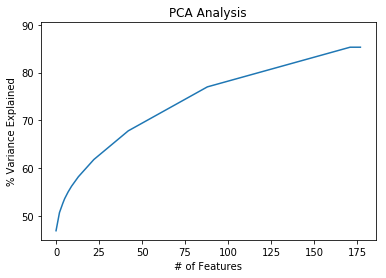

In [22]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(45,90.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

Text(0,0.5,'Frequency')

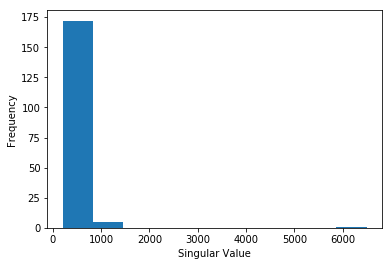

In [23]:
plt.hist(covar_matrix.singular_values_)
plt.xlabel("Singular Value")
plt.ylabel("Frequency")

Text(0,0.5,'Absolute Kurtosis')

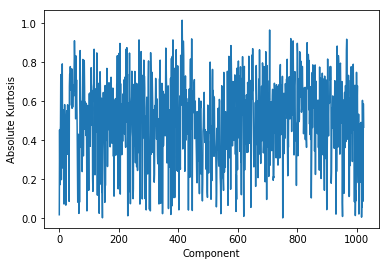

In [24]:
plt.plot(range(0, 1024), abs(kurtosis(covar_matrix.components_, axis=0)))
plt.xlabel("Component")
plt.ylabel("Absolute Kurtosis")

In [25]:
indep_matrix = FastICA(178, max_iter=1000)

In [26]:
start = time.time()
indep_matrix.fit(scaled_X_train)
end = time.time()
ica_x_scaled_time = end - start

In [27]:
indep_matrix.components_

array([[ 1.99011753e-05,  9.24198107e-06, -3.01875118e-05, ...,
        -3.19234839e-05,  1.36850019e-05,  3.88742531e-05],
       [ 6.38236052e-05,  7.15140843e-06, -5.28767527e-05, ...,
         8.79764490e-05, -3.10819366e-05, -1.20036732e-04],
       [ 2.41630619e-05,  1.67546879e-05,  1.24208916e-05, ...,
        -5.70498617e-05, -6.80333635e-05, -5.75238683e-05],
       ...,
       [ 2.73448763e-05,  1.68139286e-05, -3.39724094e-05, ...,
        -1.21921487e-05,  3.73204714e-05,  5.63122608e-05],
       [-5.05995272e-05, -8.43119174e-06,  4.20155518e-05, ...,
         2.28391576e-05,  1.80163520e-05, -8.41024342e-06],
       [ 3.43231194e-05,  1.02255921e-05, -9.79788394e-06, ...,
        -2.27930524e-05, -5.45236393e-05, -5.58793897e-05]])

Text(0,0.5,'Kurtosis')

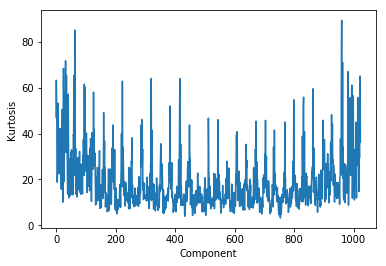

In [28]:
plt.plot(range(0, 1024), abs(kurtosis(indep_matrix.components_)))
plt.xlabel("Component")
plt.ylabel("Kurtosis")

In [47]:
pca_transform = covar_matrix.transform(scaled_X_train);
pca_reconstruct = covar_matrix.inverse_transform(pca_transform)

In [48]:
ica_transform = indep_matrix.transform(scaled_X_train);
ica_reconstruct = indep_matrix.inverse_transform(ica_transform)

In [49]:
loss_pca = ((scaled_X_train - pca_reconstruct) ** 2).mean()

In [50]:
loss_ica = ((scaled_X_train - ica_reconstruct) ** 2).mean()

In [51]:
loss_pca

0.15747987021175805

In [52]:
loss_ica

0.15694649505222522

In [53]:
pca_kmeans_models, pca_kmeans_times = kmean_fitter(pca_transform)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5
COMPLETED 6
COMPLETED 7
COMPLETED 8
COMPLETED 9
COMPLETED 10


In [54]:
pca_cluster_kmeans, pca_sse_kmeans, pca_purity_kmeans, pca_homo_kmeans = kmean_stats(pca_transform, y_train, pca_kmeans_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


In [55]:
pca_gmm_models, pca_gmm_times = gmm_fitter(pca_transform)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 10


In [56]:
pca_cluster_gmm, pca_homo_gmm, pca_purity_gmm = gmm_stats(pca_transform, y_train, pca_gmm_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


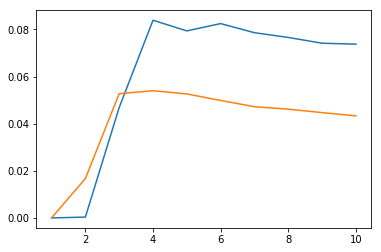

In [57]:
plt.plot(pca_cluster_gmm, pca_homo_gmm)
plt.plot(pca_cluster_kmeans, pca_homo_kmeans)

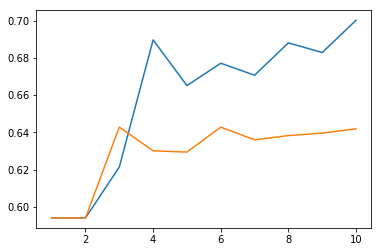

In [58]:
plt.plot(pca_cluster_gmm, pca_purity_gmm)
plt.plot(pca_cluster_kmeans, pca_purity_kmeans)

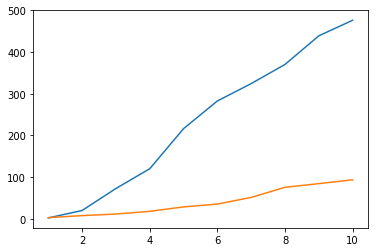

In [59]:
plt.plot(pca_cluster_gmm, pca_gmm_times)
plt.plot(pca_cluster_kmeans, pca_kmeans_times)

In [60]:
ica_kmeans_models, ica_kmeans_times = kmean_fitter(ica_transform)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5
COMPLETED 6
COMPLETED 7
COMPLETED 8
COMPLETED 9
COMPLETED 10


In [61]:
ica_cluster_kmeans, ica_sse_kmeans, ica_purity_kmeans, ica_homo_kmeans = kmean_stats(ica_transform, y_train, ica_kmeans_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


In [62]:
ica_gmm_models, ica_gmm_times = gmm_fitter(ica_transform)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5
COMPLETED 6
COMPLETED 7
COMPLETED 8
COMPLETED 9
COMPLETED 10


In [63]:
ica_cluster_gmm, ica_homo_gmm, ica_purity_gmm = gmm_stats(ica_transform, y_train, ica_gmm_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


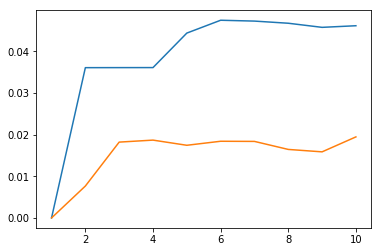

In [64]:
plt.plot(ica_cluster_gmm, ica_homo_gmm)
plt.plot(ica_cluster_kmeans, ica_homo_kmeans)

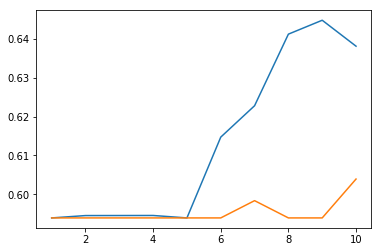

In [65]:
plt.plot(ica_cluster_gmm, ica_purity_gmm)
plt.plot(ica_cluster_kmeans, ica_purity_kmeans)

In [66]:
def get_best_rp(X_scaled):
    best_rp = None
    best_rp_loss = float("inf")
    loss_scores = []
    times = []
    for i in range(0, 200):
        rp = GaussianRandomProjection(n_components=178)
        start = time.time()
        rp.fit(X_scaled)
        end = time.time()
        times.append(end - start)
        rp_reconstruct = np.dot(rp.transform(X_scaled), rp.components_) + X_scaled.mean()
        rp_loss = ((X_scaled - rp_reconstruct ** 2)).mean().mean()
        loss_scores.append(abs(rp_loss))
        if abs(rp_loss) < best_rp_loss:
            best_rp_loss = abs(rp_loss)
            best_rp = rp
    
    return best_rp, best_rp_loss, loss_scores, times

In [67]:
best_rp, best_rp_loss, loss_scores, rp_times = get_best_rp(scaled_X_train)

Text(0,0.5,'Frequency')

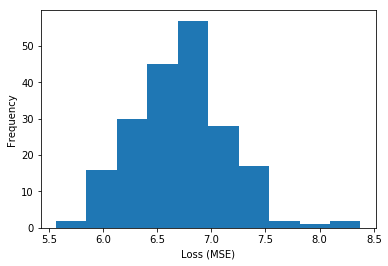

In [140]:
plt.hist(loss_scores)
plt.xlabel("Loss (MSE)")
plt.ylabel("Frequency")

In [69]:
best_rp_loss

5.5665091119197525

In [70]:
rp_transform = best_rp.transform(scaled_X_train);
rp_reconstruct = np.dot(best_rp.transform(scaled_X_train), best_rp.components_) + scaled_X_train.mean()

In [71]:
rp_kmeans_models, rp_kmeans_times = kmean_fitter(rp_transform)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5
COMPLETED 6
COMPLETED 7
COMPLETED 8
COMPLETED 9
COMPLETED 10


In [181]:
sum(rp_times)/60

0.39093398650487265

In [72]:
rp_cluster_kmeans, rp_sse_kmeans, rp_purity_kmeans, rp_homo_kmeans = kmean_stats(rp_transform, y_train, rp_kmeans_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


In [73]:
rp_gmm_models, rp_gmm_times = gmm_fitter(rp_transform)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 10


In [74]:
rp_cluster_gmm, rp_homo_gmm, rp_purity_gmm = gmm_stats(rp_transform, y_train, rp_gmm_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


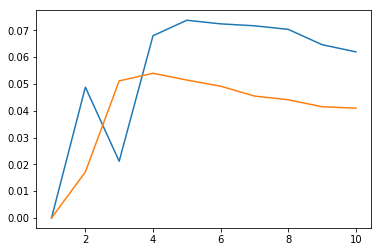

In [75]:
plt.plot(rp_cluster_gmm, rp_homo_gmm)
plt.plot(rp_cluster_kmeans, rp_homo_kmeans)

In [76]:
def get_autoencoder():  
    input_img = Input(shape=(32, 32, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(12, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    optimizer = Adam(lr=.0005)
    autoencoder.compile(optimizer=optimizer, loss='mse')
        
    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)
    
    return autoencoder, encoder;

In [77]:
autoencoder, encoder = get_autoencoder()

In [78]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 12)        1740      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 12)          1308      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 12)          0         
__________

In [79]:
reshaped_scaled_X_train = scaled_X_train.reshape(len(scaled_X_train), 32, 32, 1)

In [80]:
history = autoencoder.fit(reshaped_scaled_X_train, reshaped_scaled_X_train,
                epochs=50, batch_size=32, 
                verbose=2, callbacks=[TQDMNotebookCallback()])

Epoch 1/50


 - 22s - loss: 0.6889
Epoch 2/50


 - 20s - loss: 0.6631
Epoch 3/50


 - 20s - loss: 0.6577
Epoch 4/50


 - 20s - loss: 0.6545
Epoch 5/50


 - 20s - loss: 0.6524
Epoch 6/50


 - 20s - loss: 0.6509
Epoch 7/50


 - 20s - loss: 0.6499
Epoch 8/50


 - 20s - loss: 0.6491
Epoch 9/50


 - 20s - loss: 0.6483
Epoch 10/50


 - 20s - loss: 0.6477
Epoch 11/50


 - 20s - loss: 0.6471
Epoch 12/50


 - 20s - loss: 0.6465
Epoch 13/50


 - 20s - loss: 0.6460
Epoch 14/50


 - 20s - loss: 0.6456
Epoch 15/50


 - 20s - loss: 0.6451
Epoch 16/50


 - 20s - loss: 0.6447
Epoch 17/50


 - 20s - loss: 0.6443
Epoch 18/50


 - 20s - loss: 0.6439
Epoch 19/50


 - 20s - loss: 0.6435
Epoch 20/50


 - 20s - loss: 0.6432
Epoch 21/50


 - 20s - loss: 0.6429
Epoch 22/50


 - 20s - loss: 0.6426
Epoch 23/50


 - 20s - loss: 0.6423
Epoch 24/50


 - 20s - loss: 0.6421
Epoch 25/50


 - 20s - loss: 0.6418
Epoch 26/50


 - 20s - loss: 0.6416
Epoch 27/50


 - 20s - loss: 0.6413
Epoch 28/50


 - 20s - loss: 0.6411
Epoch 29/50


 - 20s - loss: 0.6409
Epoch 30/50


 - 20s - loss: 0.6407
Epoch 31/50


 - 20s - loss: 0.6405
Epoch 32/50


 - 20s - loss: 0.6404
Epoch 33/50


 - 20s - loss: 0.6402
Epoch 34/50


 - 20s - loss: 0.6400
Epoch 35/50


 - 20s - loss: 0.6399
Epoch 36/50


 - 20s - loss: 0.6398
Epoch 37/50


 - 20s - loss: 0.6397
Epoch 38/50


 - 20s - loss: 0.6395
Epoch 39/50


 - 20s - loss: 0.6395
Epoch 40/50


 - 20s - loss: 0.6394
Epoch 41/50


 - 20s - loss: 0.6393
Epoch 42/50


 - 20s - loss: 0.6392
Epoch 43/50


 - 20s - loss: 0.6391
Epoch 44/50


 - 20s - loss: 0.6391
Epoch 45/50


 - 20s - loss: 0.6390
Epoch 46/50


 - 20s - loss: 0.6390
Epoch 47/50


 - 20s - loss: 0.6389
Epoch 48/50


 - 20s - loss: 0.6388
Epoch 49/50


 - 20s - loss: 0.6388
Epoch 50/50


 - 20s - loss: 0.6387



In [81]:
encoder_transform_raw = encoder.predict(reshaped_scaled_X_train)

In [82]:
encoder_transform = encoder_transform_raw.reshape(len(encoder_transform_raw), 192)

In [83]:
encoder_kmeans_models, encoder_kmeans_times = kmean_fitter(encoder_transform)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4
COMPLETED 5
COMPLETED 6
COMPLETED 7
COMPLETED 8
COMPLETED 9
COMPLETED 10


In [84]:
encoder_cluster_kmeans, encoder_sse_kmeans, encoder_purity_kmeans, encoder_homo_kmeans = kmean_stats(encoder_transform, y_train, encoder_kmeans_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


In [85]:
encoder_gmm_models, encoder_gmm_times = gmm_fitter(encoder_transform)

COMPLETED 1
COMPLETED 2
COMPLETED 3
COMPLETED 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 5
COMPLETED 6
COMPLETED 7
COMPLETED 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


COMPLETED 10


In [86]:
encoder_cluster_gmm, encoder_homo_gmm, encoder_purity_gmm = gmm_stats(encoder_transform, y_train, encoder_gmm_models)

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10


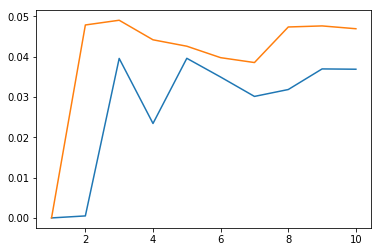

In [87]:
plt.plot(encoder_cluster_gmm, encoder_homo_gmm)
plt.plot(encoder_cluster_kmeans, encoder_homo_kmeans)

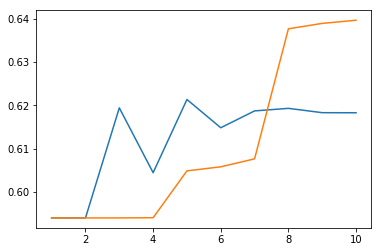

In [88]:
plt.plot(encoder_cluster_gmm, encoder_purity_gmm)
plt.plot(encoder_cluster_kmeans, encoder_purity_kmeans)

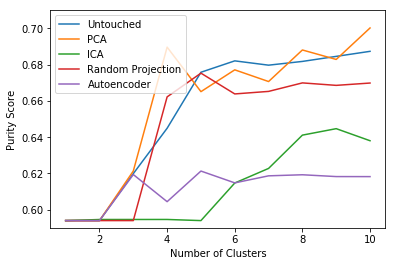

In [116]:
plt.plot(encoder_cluster_gmm, purity_gmm)
plt.plot(encoder_cluster_gmm, pca_purity_gmm)
plt.plot(encoder_cluster_gmm, ica_purity_gmm)
plt.plot(encoder_cluster_gmm, rp_purity_gmm)
plt.plot(encoder_cluster_gmm, encoder_purity_gmm)
plt.ylim(.59, .71)
plt.xlabel("Number of Clusters")
plt.ylabel("Purity Score")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

In [130]:
print(purity_kmeans[2])
print(homo_kmeans[2])

0.6428701283945006
0.05280530381983992


In [213]:
print(encoder_purity_kmeans[8])
print(encoder_homo_kmeans[8])

0.6388819452334962
0.0476434045346606


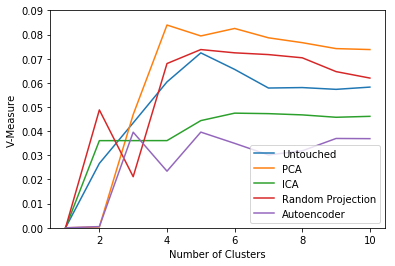

In [123]:
plt.plot(encoder_cluster_gmm, homo_gmm)
plt.plot(encoder_cluster_gmm, pca_homo_gmm)
plt.plot(encoder_cluster_gmm, ica_homo_gmm)
plt.plot(encoder_cluster_gmm, rp_homo_gmm)
plt.plot(encoder_cluster_gmm, encoder_homo_gmm)
plt.xlabel("Number of Clusters")
plt.ylabel("V-Measure")
plt.ylim(0, .09)
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

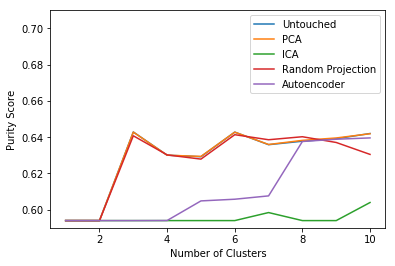

In [117]:
plt.plot(encoder_cluster_kmeans, purity_kmeans)
plt.plot(encoder_cluster_kmeans, pca_purity_kmeans)
plt.plot(encoder_cluster_kmeans, ica_purity_kmeans)
plt.plot(encoder_cluster_kmeans, rp_purity_kmeans)
plt.plot(encoder_cluster_kmeans, encoder_purity_kmeans)
plt.ylim(.59, .71)
plt.xlabel("Number of Clusters")
plt.ylabel("Purity Score")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

In [204]:
print(encoder_purity_kmeans[7])
print(encoder_homo_kmeans[7])

0.6376320872628111
0.047380766173842424


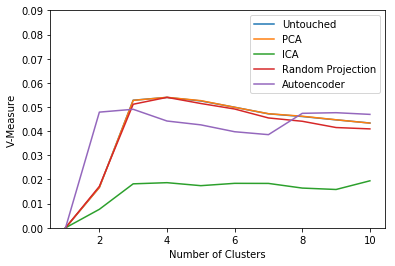

In [122]:
plt.plot(encoder_cluster_kmeans, homo_kmeans)
plt.plot(encoder_cluster_kmeans, pca_homo_kmeans)
plt.plot(encoder_cluster_kmeans, ica_homo_kmeans)
plt.plot(encoder_cluster_kmeans, rp_homo_kmeans)
plt.plot(encoder_cluster_kmeans, encoder_homo_kmeans)
plt.ylim(0, .09)
plt.xlabel("Number of Clusters")
plt.ylabel("V-Measure")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

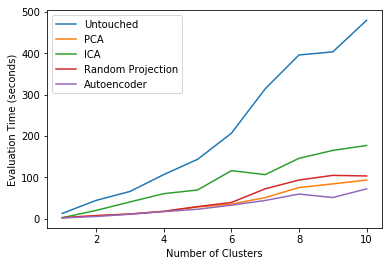

In [104]:
plt.plot(encoder_cluster_kmeans, kmeans_times)
plt.plot(encoder_cluster_kmeans, pca_kmeans_times)
plt.plot(encoder_cluster_kmeans, ica_kmeans_times)
plt.plot(encoder_cluster_kmeans, rp_kmeans_times)
plt.plot(encoder_cluster_kmeans, encoder_kmeans_times)
plt.xlabel("Number of Clusters")
plt.ylabel("Evaluation Time (seconds)")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

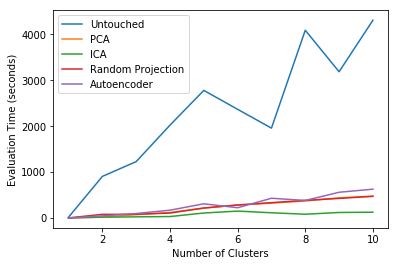

In [105]:
plt.plot(encoder_cluster_kmeans, gmm_times)
plt.plot(encoder_cluster_kmeans, pca_gmm_times)
plt.plot(encoder_cluster_kmeans, ica_gmm_times)
plt.plot(encoder_cluster_kmeans, rp_gmm_times)
plt.plot(encoder_cluster_kmeans, encoder_gmm_times)
plt.xlabel("Number of Clusters")
plt.ylabel("Evaluation Time (seconds)")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

In [141]:
gmm_models

[GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=1, n_init=1, precisions_init=None,
         random_state=420, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None),
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=2, n_init=1, precisions_init=None,
         random_state=420, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None),
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=3, n_init=1, precisions_init=None,
         random_state=420, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None),
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=4, n_init=1, precisions_init=

In [156]:
huh = ica_kmeans_models[2]

In [151]:
why = pca_kmeans_models[2]

In [152]:
tho = kmeans_models[2]

In [164]:
tho.tol

0.0001

In [178]:
pca_x_scaled_time/60

0.1198129932085673

In [177]:
ica_x_scaled_time/60

1.2228803753852844

In [179]:
16 + 43/60

16.716666666666665